In [1]:
%pip install transformers

     |████████████████████████████████| 368kB 35.4MB/s 
     |████████████████████████████████| 860kB 45.2MB/s 
     |████████████████████████████████| 645kB 48.2MB/s 
     |████████████████████████████████| 1.0MB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=ea919923555acbd8c45c0f1960eb519c152337572bb6ab2c7c57ef225c13cb48
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.59
transformers version : 2.2.1


In [0]:
DATASETS_URL = {
    'wikitext-2':   {'train': "https://s3.amazonaws.com/datasets.huggingface.co/wikitext-2/train.txt",
                     'valid': "https://s3.amazonaws.com/datasets.huggingface.co/wikitext-2/valid.txt"},
    'wikitext-103': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/wikitext-103/wiki.train.tokens",
                     'valid': "https://s3.amazonaws.com/datasets.huggingface.co/wikitext-103/wiki.valid.tokens"},
    'simplebooks-2-raw': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/simplebooks-2-raw/train.txt",
                          'valid': "https://s3.amazonaws.com/datasets.huggingface.co/simplebooks-2-raw/valid.txt"},
    'simplebooks-92-raw': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/simplebooks-92-raw/train.txt",
                           'valid': "https://s3.amazonaws.com/datasets.huggingface.co/simplebooks-92-raw/valid.txt"},
    'imdb': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/aclImdb/train.txt",
             'test': "https://s3.amazonaws.com/datasets.huggingface.co/aclImdb/test.txt"},
    'trec': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/trec/train.txt",
             'test': "https://s3.amazonaws.com/datasets.huggingface.co/trec/test.txt"},
    }

DATASETS_LABELS_URL = {
    'imdb': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/aclImdb/train.labels.txt",
             'test': "https://s3.amazonaws.com/datasets.huggingface.co/aclImdb/test.labels.txt"},
    'trec': {'train': "https://s3.amazonaws.com/datasets.huggingface.co/trec/train.labels.txt",
             'test': "https://s3.amazonaws.com/datasets.huggingface.co/trec/test.labels.txt"},
    }

DATASETS_LABELS_CONVERSION = {
    'imdb':         {'pos': 0, 'neg': 1},
    'trec':         {'NUM': 0, 'LOC': 1, 'HUM': 2, 'DESC': 3, 'ENTY': 4, 'ABBR': 5},
    }

In [5]:

train = pd.read_csv('https://raw.githubusercontent.com/loretoparisi/bert_text_classifier/master/data/imdb_kaggle/train.tsv', sep="\t", quoting=csv.QUOTE_ALL, engine="python", quotechar='"', encoding="utf-8")
test = pd.read_csv('https://raw.githubusercontent.com/loretoparisi/bert_text_classifier/master/data/imdb_kaggle/test.tsv', sep="\t", quoting=csv.QUOTE_ALL, engine="python", quotechar='"', encoding="utf-8")

print(train.shape, test.shape)
train.head()
test.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [0]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [9]:
model_class.pretrained_model_archive_map.keys()


dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [0]:
seed_all(seed)

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

100%|██████████| 456318/456318 [00:01<00:00, 427806.28B/s]


In [14]:
tokenizer_class.pretrained_vocab_files_map

{'merges_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-merges.txt',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt',
  'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-merges.txt',
  'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt'},
 'vocab_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-vocab.json',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'robert

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [18]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [19]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> Ġ- L RB - ĠCity Ġ- RR B - Ġreminds Ġus Ġhow Ġrealistically Ġnuanced Ġa ĠRobert ĠDe ĠN iro Ġperformance Ġcan Ġbe Ġwhen Ġhe Ġis Ġnot Ġmore Ġluc r atively Ġengaged Ġin Ġthe Ġshameless Ġself - car ic ature Ġof Ġ` ĠAnaly ze ĠThis Ġ' Ġ- L RB - Ġ1999 Ġ- RR B - Ġand Ġ` ĠAnaly ze ĠThat Ġ, Ġ' Ġpromised Ġ- L RB - Ġor Ġthreatened Ġ-",3
"<s> ĠThe Ġreal Ġtriumph s Ġin ĠIg by Ġcome Ġfrom ĠPhilippe Ġ, Ġwho Ġmakes ĠOliver Ġfar Ġmore Ġinteresting Ġthan Ġthe Ġcharacter Ġ' s Ġlines Ġwould Ġsuggest Ġ, Ġand ĠSar andon Ġ, Ġwho Ġcould Ġn 't Ġbe Ġbetter Ġas Ġa Ġcruel Ġbut Ġweird ly Ġlik able ĠWAS P Ġmat ron Ġ. </s>",3
"<s> ĠParker Ġshould Ġbe Ġcomm ended Ġfor Ġtaking Ġa Ġfresh Ġapproach Ġto Ġfamiliar Ġmaterial Ġ, Ġbut Ġhis Ġdetermination Ġto Ġremain Ġtrue Ġto Ġthe Ġoriginal Ġtext Ġleads Ġhim Ġto Ġadopt Ġa Ġsomewhat Ġman nered Ġtone Ġ... Ġthat Ġultimately Ġdull s Ġthe Ġhuman Ġtragedy Ġat Ġthe Ġstory Ġ' s Ġcore </s>",2
"<s> ĠIt Ġ' s Ġa Ġlong Ġway Ġfrom ĠOrwell Ġ' s Ġdark Ġ, Ġintelligent Ġwarning Ġcry Ġ- L RB - Ġ1984 Ġ- RR B - Ġto Ġthe Ġempty Ġstud Ġknock about Ġof ĠEqu ilibrium Ġ, Ġand Ġwhat Ġonce Ġwas Ġconviction Ġis Ġnow Ġaffect ation Ġ. </s>",1
"<s> ĠA Ġdifferent Ġand Ġemotionally Ġreserved Ġtype Ġof Ġsurvival Ġstory Ġ-- Ġa Ġfilm Ġless Ġabout Ġref ract ing Ġall Ġof ĠWorld ĠWar ĠII Ġthrough Ġthe Ġspecific Ġconditions Ġof Ġone Ġman Ġ, Ġand Ġmore Ġabout Ġthat Ġman Ġlost Ġin Ġits Ġmidst Ġ. </s>",3


In [20]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 79])
tensor([[    0,   111,   574,  ...,    76,   479,     2],
        [    0,    33,     7,  ...,     1,     1,     1],
        [    0,   318,    47,  ...,     1,     1,     1],
        ...,
        [    0,     5,  2156,  ...,     1,     1,     1],
        [    0,    33, 30291,  ...,     1,     1,     1],
        [    0, 45518, 10730,  ...,     1,     1,     1]])


In [0]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [22]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

100%|██████████| 473/473 [00:00<00:00, 264063.06B/s]

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [23]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

100%|██████████| 501200538/501200538 [00:40<00:00, 12265413.28B/s]


In [0]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [25]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [0]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [27]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

In [0]:
learner.save('untrain')

In [0]:
seed_all(seed)
learner.load('untrain');

In [0]:
learner.freeze_to(-1)

In [31]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [79, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [79, 768]            394,752    False     
______________________________________________________________________
Embedding            [79, 768]            768        False     
______________________________________________________________________
LayerNorm            [79, 768]            1,536      False     
______________________________________________________________________
Dropout              [79, 768]            0          False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
_______________________________________

In [32]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.91E-05


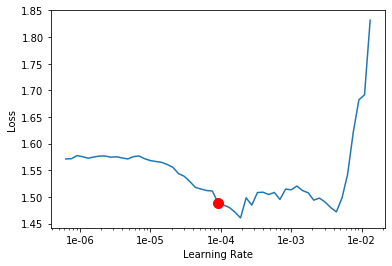

In [33]:
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.039410,0.992927,0.595925,04:24


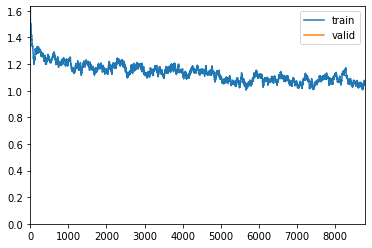

In [34]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [0]:
learner.save('first_cycle')

In [0]:
seed_all(seed)

In [0]:
learner.load('first_cycle');

In [0]:
learner.freeze_to(-2)

In [0]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,time
0,0.922088,0.907487,0.633346,05:44


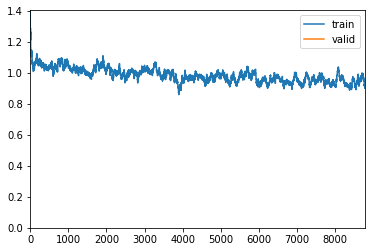

In [40]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('second_cycle')

In [0]:
seed_all(seed)
learner.load('second_cycle');

In [0]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.868388,0.873505,0.645905,07:00


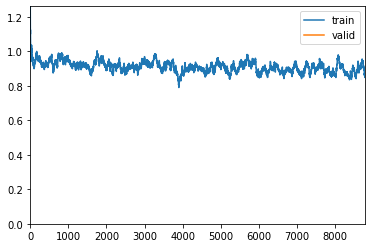

In [45]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('third_cycle')

In [0]:
seed_all(seed)
learner.load('third_cycle')

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.717738,0.715656,0.701012,22:59
1,0.666703,0.697965,0.707933,22:05


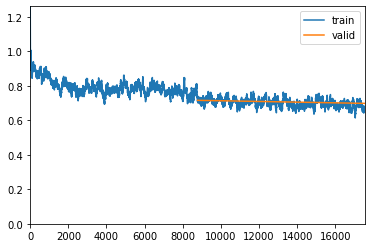

In [49]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [50]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [53]:
sample_submission = pd.read_csv('https://raw.githubusercontent.com/loretoparisi/bert_text_classifier/master/data/imdb_kaggle/sampleSubmission.csv', quoting=csv.QUOTE_ALL, engine="python", quotechar='"', encoding="utf-8")
print(sample_submission.shape)
sample_submission.head()

(66292, 2)


,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [0]:
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)

In [55]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [56]:
sample_submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [59]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predictions.csv')